In [1]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.01

Files already downloaded and verified
Files already downloaded and verified


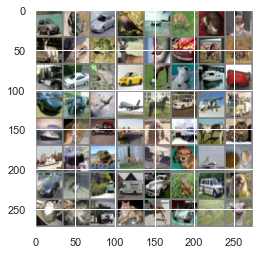

In [4]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.covModule = nn.Sequential(
            #input a 3x32x32 image
            nn.Conv2d(3, 64, (5,5)),  #image size will be 64x28x28
            nn.MaxPool2d(2, 2),#image size will be 64x14x14
            nn.Conv2d(64, 64, (5,5)), #image size will be 64x10x10
            nn.MaxPool2d(2, 2), #image size will be 64x5x5
            nn.Conv2d(64, 128, (5,5)) #image size will be 64x1x1
            #nn.MaxPool2d(2, 2), #image size will be 128x1x1
        )
        self.fcModule = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            #nn.Softmax() #no need for softmax ans CrossEntropy loss already has it
        )
    def forward(self, x):
        x = self.covModule(x)
        x = x.view(-1, 1*1*128)
        output = self.fcModule(x)
        return output

In [6]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [7]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Epoch [1/150], Step [200/782], Loss: 2.1956
Epoch [1/150], Step [400/782], Loss: 2.0792
Epoch [1/150], Step [600/782], Loss: 1.9079
Epoch [2/150], Step [200/782], Loss: 1.9089
Epoch [2/150], Step [400/782], Loss: 1.7926
Epoch [2/150], Step [600/782], Loss: 1.6904
Epoch [3/150], Step [200/782], Loss: 1.5998
Epoch [3/150], Step [400/782], Loss: 1.7548
Epoch [3/150], Step [600/782], Loss: 1.5118
Epoch [4/150], Step [200/782], Loss: 1.5557
Epoch [4/150], Step [400/782], Loss: 1.6507
Epoch [4/150], Step [600/782], Loss: 1.3568
Epoch [5/150], Step [200/782], Loss: 1.6735
Epoch [5/150], Step [400/782], Loss: 1.5241
Epoch [5/150], Step [600/782], Loss: 1.4875
Epoch [6/150], Step [200/782], Loss: 1.4394
Epoch [6/150], Step [400/782], Loss: 1.3471
Epoch [6/150], Step [600/782], Loss: 1.4679
Epoch [7/150], Step [200/782], Loss: 1.4430
Epoch [7/150], Step [400/782], Loss: 1.3831
Epoch [7/150], Step [600/782], Loss: 1.4961
Epoch [8/150], Step [200/782], Loss: 1.6141
Epoch [8/150], Step [400/782], L

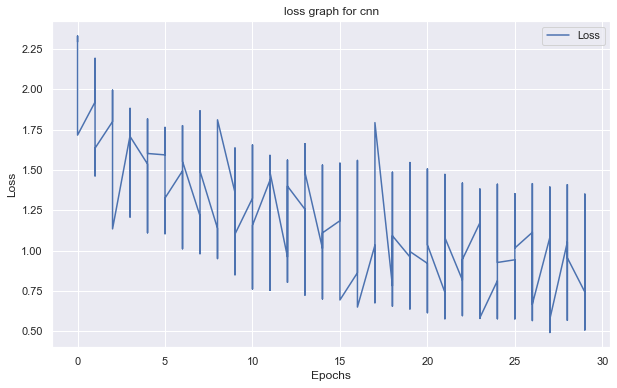

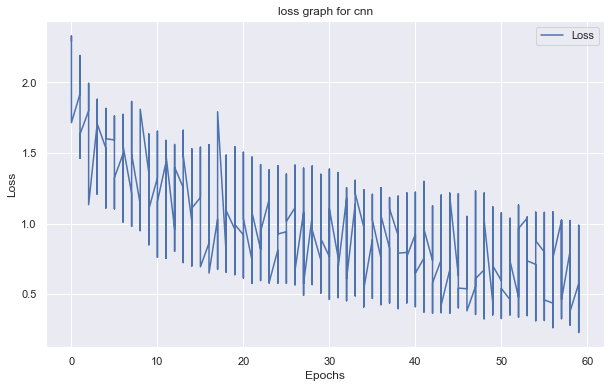

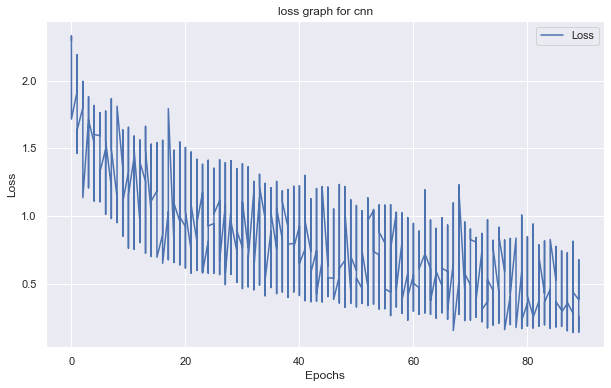

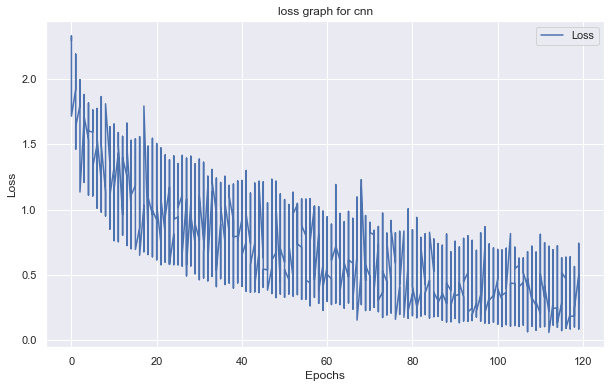

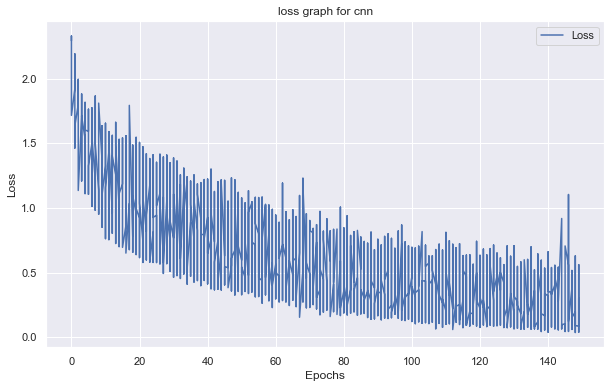

In [8]:
loss_history = []
epochs = []
n_total_steps = len(train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    if epoch == 60:
        learning_rate = learning_rate/10
    if epoch == 120:
        learning_rate = learning_rate/10
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss.item())
        epochs.append(epoch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch+1) % 30 == 0:
        plotLosses(epochs, loss_history, 'loss graph for cnn')

print("--- %s seconds ---" % (time.time() - start_time))

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

In [9]:

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 61.67 %
Accuracy of plane: 70.0 %
Accuracy of car: 75.6 %
Accuracy of bird: 59.0 %
Accuracy of cat: 38.8 %
Accuracy of deer: 52.1 %
Accuracy of dog: 54.2 %
Accuracy of frog: 67.1 %
Accuracy of horse: 64.2 %
Accuracy of ship: 72.7 %
Accuracy of truck: 63.0 %


In [10]:
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

In [11]:
trial = torchbearer.Trial(model, optimizer, criterion, metrics=['loss', 'accuracy', 'top_5_acc'])
trial.with_generators(train_loader, test_generator=test_loader)

trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

0/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

1/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

2/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

3/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

4/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

5/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

6/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

7/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

8/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

9/10(t):   0%|          | 0/782 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/157 [00:00<?, ?it/s]

{'test_loss': 2.241917848587036, 'test_acc': 0.6531999707221985, 'test_top_5_acc': 0.9578999876976013}


In [12]:
print(test_loader.items)

AttributeError: 'DataLoader' object has no attribute 'items'

In [ ]:
print(len(epochs))
print(len(loss_history))

In [ ]:
plt.plot(epochs,loss_history)
print(len(train_loader))